#### import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GRU, LSTM, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
import matplotlib.pyplot as plt
import os
from itertools import chain

#### define f1 callback class

In [3]:
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        predictions = np.argmax(self.model.predict(X_val), axis=1)
        true_labels = np.argmax(y_val, axis=1)
        f1 = f1_score(true_labels, predictions, average='weighted')
        self.f1_scores.append(f1)
        print(f"Epoch {epoch + 1}: F1-Score: {f1:.4f}")

##### Learning rate scheduler function

In [4]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.96

#### Collect Data

In [2]:
# Data Collection
####################### Please change this to your 
main_folder = "C:\Me\VScode\extracted_files\AISContest_Data"

# List to store all file paths
final_file_list = []

# Process folders from 0 to 4
for label in range(5):
    folder_path = os.path.join(main_folder, str(label))
    
    if not os.path.exists(folder_path):  # Check if folder exists
        print(f"Warning: Folder {folder_path} does not exist.")
        continue
    
    print(f"Processing folder: {folder_path}")
    
    # Collect all .npy files in the folder
    file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".npy")]
    final_file_list.append(file_list)
    print(f"Found {len(file_list)} files in folder {label}.")

# Flatten the list of lists into one list
file_list = list(chain.from_iterable(final_file_list))

# Load data and labels
data_list = []
labels_list = []

for file_path in file_list:
    label = int(os.path.basename(os.path.dirname(file_path)))  # Extract label from folder name
    data = np.load(file_path)  # Load data from .npy file
    data_list.append(data)
    labels_list.append(label)

data_array = np.stack(data_list, axis=0)
labels_array = np.array(labels_list)


<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
C:\Users\User\AppData\Local\Temp\ipykernel_34524\2706336531.py:3: SyntaxWarning: invalid escape sequence '\M'
  main_folder = "C:\Me\VScode\extracted_files\AISContest_Data"


Processing folder: C:\Me\VScode\extracted_files\AISContest_Data\0
Found 2906 files in folder 0.
Processing folder: C:\Me\VScode\extracted_files\AISContest_Data\1
Found 237 files in folder 1.
Processing folder: C:\Me\VScode\extracted_files\AISContest_Data\2
Found 1755 files in folder 2.
Processing folder: C:\Me\VScode\extracted_files\AISContest_Data\3
Found 497 files in folder 3.
Processing folder: C:\Me\VScode\extracted_files\AISContest_Data\4
Found 418 files in folder 4.


##### Check data

In [5]:
print(f"Data shape: {data_array.shape}")
print(f"Labels shape: {labels_array.shape}")

Data shape: (5813, 51, 59, 1)
Labels shape: (5813,)


#### Normalize data

In [6]:
scaler = StandardScaler()
data_array_flat = data_array.reshape(-1, data_array.shape[2])
data_array_flat = scaler.fit_transform(data_array_flat)
data_array = data_array_flat.reshape(-1, 51, data_array.shape[2], 1)


#### Handle data with SMOTE

In [7]:
X_flat = data_array.reshape(data_array.shape[0], -1)
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_flat, labels_array)
data_array = X_resampled.reshape(-1, 51, data_array.shape[2], 1)

# Convert labels to one-hot encoding
labels_array = to_categorical(y_resampled, num_classes=5)


#### Split data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data_array, labels_array, test_size=0.2, random_state=42, shuffle=True
)

#### Callbacks

In [9]:
f1_callback = F1ScoreCallback(validation_data=(X_test, y_test))
callbacks = [
    LearningRateScheduler(scheduler),
    f1_callback
]

#### Model architecture
##### and Compile

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(51, 59, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Reshape((11, -1)),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])


# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Train data and save training history

In [11]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step   - accuracy: 0.2
Epoch 1: F1-Score: 0.0728
364/364 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.2829 - loss: 1.6153 - val_accuracy: 0.2068 - val_loss: 4.8944 - learning_rate: 0.0010
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/stepep - accuracy: 0.45
Epoch 2: F1-Score: 0.4181
364/364 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.4526 - loss: 1.2913 - val_accuracy: 0.4150 - val_loss: 1.3115 - learning_rate: 0.0010
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step ep - accuracy: 0.61
Epoch 3: F1-Score: 0.1611
364/364 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.6146 - loss: 0.9411 - val_accuracy: 0.2540 - val_loss: 3.3277 - learning_rate: 0.0010
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/stepep - accuracy: 0.7
Epoch 4: F1-Score: 0.3795
364/364 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7092 - loss: 0.6811 - val_accuracy: 0.4233 - val_loss: 1.7297 - learning_rate: 0.0010
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9

### Evaluate Model and Compute f1 Score

In [12]:
# Evaluate model
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute F1-Score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f"Final F1-Score: {f1:.4f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Final F1-Score: 0.8455


#### Plot f1 Score over  each epoch

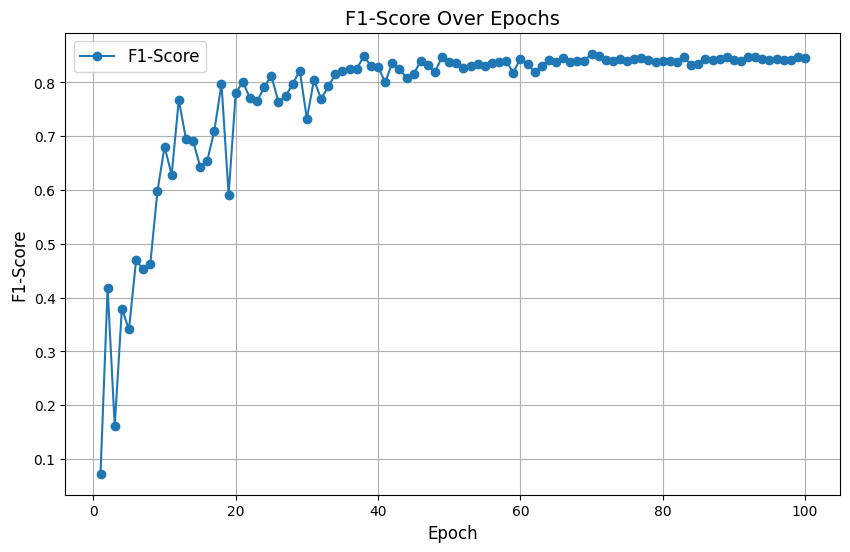

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(f1_callback.f1_scores) + 1), f1_callback.f1_scores, marker='o', label='F1-Score')
plt.title('F1-Score Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()